- Author: Peter Steiglechner
- Start Date: Jan 2024

> **The core idea**: Using data from the ESS about Germans' climate change opinions in 2016 and in 2020 to estimate subjective actual and perceived opinion polarisation based on social identities. This notebook produces visualisations of the Analysis:
> - results table
> - PxA plots for the different in-groups and different degrees of bias 
> - Bootstrap Plot showing the robustness of the polarisation measures under smaller datasets

In [1]:
from main import *

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix

sns.set_style("ticks", {"axes.linewidth":0.5})
smallfs = 8
bigfs = 10
plt.rc('font', size=smallfs)          # Ticklabels, legend labels, etc.
plt.rc('axes', labelsize=bigfs)    # Axis labels
plt.rc('axes', titlesize=bigfs)    # Titles

In [2]:
colours = dict(zip(["Union", "SPD", "Left Party", "Greens", "FDP", "AfD", "None"], ["#000000", "#E3000F", "#b61c3e", "#1AA037", "#FFEF00", "#0489DB", "grey"]))  # 

kuerzel2party = {"u":"Union", "s":"SPD", "l":"Left Party", "g":"Greens", "f":"FDP", "a":"AfD", "n":"None"}


In [3]:
folder = "inputdata/"

# Load data
cntry = "DE"
variables = ["ccnthum", "wrclmch"]
variables_na = {"ccnthum": [55, 66, 77, 88, 99], "wrclmch": [6, 7, 8, 9]} 
waves = [8, 10]

# Define German parties
wave_t0_prtcl = "prtclede"
wave_t1_prtcl = "prtclfde"

ESSparty_dict_t0 = {
    1: "Union",
    2: "SPD",
    3: "Left Party",
    4: "Greens", 
    5: "FDP",
    6: "AfD"
}
for p in [7,8,9]: # coded "other Party" as np.nan
    ESSparty_dict_t0[p] = -1
ESSparty_dict_t1 = ESSparty_dict_t0
for p in [7,8,9]: # coded "other Party" as np.nan
    ESSparty_dict_t1[p] = -1
for p in [66,88]: # coded as separate "None" fraction 
    ESSparty_dict_t0[p] = "None"
    ESSparty_dict_t1[p] = "None"

parties = ["Left Party", "Greens", "SPD", "None", "FDP", "Union", "AfD"]
assert all([((p in ESSparty_dict_t0.values()) and (p in ESSparty_dict_t1.values())) for p in parties])


cols = ["essround", "anweight", "cntry", "prtdgcl"] + variables
rawdataC = pd.concat(
        [
            pd.read_csv(f"{folder}{essfile}.csv", 
                        usecols=cols + [prtclcol]) 
            for essfile, prtclcol in zip(["ESS8e02_3", "ESS10SC"], [wave_t0_prtcl, wave_t1_prtcl])
        ], 
        axis=0
    )
data = rawdataC.loc[rawdataC.cntry == cntry]
data = data.reset_index()


# Run analysis

data = prepareData(data, wave_t0_prtcl, wave_t1_prtcl, ESSparty_dict_t0, ESSparty_dict_t1, variables=variables, variables_na=variables_na)
filtered_data = data.dropna(subset=["identity"]+variables, how="any", axis="index")
CSS_dict, Trafo = get_Trafo(filtered_data, parties=parties, waves=waves, variables=variables)
meand_w0, meand_w1 = calc_polarisation(filtered_data, waves=waves, variables=variables, Trafo=Trafo)
PxA_0_md, PxA_1_md, PxP_0_md, PxP_1_md = calc_polarisation_PxPs(filtered_data, waves=waves, parties=parties, variables=variables, Trafo=Trafo)


# Print 

# P_perc = meand_w1[10][10] - meand_w1[8][8]
# P_X = meand_w1[10][10] - meand_w1[10][8]
# P_actual = meand_w1[10][8] - meand_w1[8][8]

def print_table(DM, t0,t1, w):
    P_perc = DM[t1][t1] - DM[t0][t0]
    tableVal = r"   & T_t0 & T_t1 & P_X"+ "\n \t"+\
        rf"X_t0  &  {DM[t0][t0]:.3f} &  . &  . "+"\n \t"+\
        rf"X_t1 &  {DM[t1][t0]:.3f} &  {DM[t1][t1]:.3f} & {(DM[t1][t1]-DM[t1][t0]):.3f}   "+"\n \t"+\
        rf"P_actual  &  {(DM[t1][t0]-DM[t0][t0]):.3f}  & .. &  P_perc = {P_perc:.3f}  "
    print(f"---\n w={w}:\n \t {tableVal}")
    return

print();print("All by All")
print_table(meand_w0, waves[0], waves[1], 0)
print(); print("All by All")
print_table(meand_w1, waves[0], waves[1], 1)
print("")
for p in parties:
    print(p)
    pl = p[0].lower()
    print_table(
        dict(zip(waves, [dict(zip(waves, [PxA_1_md[r][C][pl] for C in waves[:n+1]])) for n, r in enumerate(waves)])),
        8, 10, 1)
    print("")

Opinions from wave 8 (# (2737,)), with transformation matrices from wave 8. Time elapsed: 0s
Opinions from wave 10 (# (7807,)), with transformation matrices from wave 8. Time elapsed: 4s
Opinions from wave 10 (# (7807,)), with transformation matrices from wave 10. Time elapsed: 8s
Left Party
wave 8  --> done (0 seconds, n=151)
wave 10  --> done (2 seconds, n=314)
Greens
wave 8  --> done (0 seconds, n=219)
wave 10  --> done (5 seconds, n=950)
SPD
wave 8  --> done (1 seconds, n=392)
wave 10  --> done (4 seconds, n=967)
None
wave 8  --> done (2 seconds, n=1342)
wave 10  --> done (12 seconds, n=4017)
FDP
wave 8  --> done (0 seconds, n=52)
wave 10  --> done (3 seconds, n=395)
Union
wave 8  --> done (2 seconds, n=484)
wave 10  --> done (5 seconds, n=990)
AfD
wave 8  --> done (0 seconds, n=97)
wave 10  --> done (1 seconds, n=174)

All by All
---
 w=0:
 	    & T_t0 & T_t1 & P_X
 	X_t0  &  1.709 &  . &  . 
 	X_t1 &  1.759 &  1.741 & -0.018   
 	P_actual  &  0.050  & .. &  P_perc = 0.032  

All 

# Objective

In [4]:
Aobjd = {} 
Aobjmd = {}
SigAobjmd = {}
for r in waves:
    df = filtered_data.loc[filtered_data.essround==r, :]
    obs = df
    Aobjd[r] = distance_matrix(obs[variables].to_numpy(), obs[variables].to_numpy())
    Aobjmd[r] = avg_distances( Aobjd[r], obs.anweight, obs.anweight, True)
    SigAobjmd[r] = np.std(obs[variables].to_numpy())
print("objective")
print(", ".join([f"d_obj({k}): {v:.3f}" for k, v in Aobjmd.items()]), ",  P^{obj}="+f"{(Aobjmd[waves[1]]-Aobjmd[waves[0]]):.3f}")


objective
d_obj(8): 1.321, d_obj(10): 1.393 ,  P^{obj}=0.072


# PxA Figure

In [5]:
# store results PxP and PxA in dataframe

perspectives = np.array([[a[0].lower()+b[0].lower() for a in parties] for b in parties]).flatten()

obs = [p[0] for p in perspectives]
obd = [p[1] for p in perspectives]

d1010s_w1 = np.array([PxP_1_md[10][10][pers] for pers in perspectives])
d88s_w1 = np.array([PxP_1_md[8][8][pers] for pers in perspectives])
d108s_w1 = np.array([PxP_1_md[10][8][pers] for pers in perspectives])

dfPxP = pd.DataFrame({"obs":obs, "obd":obd, 
                      "d1010_w1":d1010s_w1,"d108_w1":d108s_w1,"d88_w1":d88s_w1, 
                    }, index=perspectives)
dfPxP["Pol_w1"] = dfPxP["d1010_w1"]-dfPxP["d88_w1"] 
dfPxP["OP_w1"] = dfPxP["d108_w1"] - dfPxP["d88_w1"] 
dfPxP["PP_w1"] = dfPxP["d1010_w1"] - dfPxP["d108_w1"]

d1010s_w0 = np.array([PxP_0_md[10][10][pers] for pers in perspectives])
d88s_w0 = np.array([PxP_0_md[8][8][pers] for pers in perspectives])
d108s_w0 = np.array([PxP_0_md[10][8][pers] for pers in perspectives])
dfPxP["Pol_w0"] = d1010s_w0 - d88s_w0
dfPxP["OP_w0"] = d108s_w0 - d88s_w0
dfPxP["PP_w0"] = d1010s_w0 -d108s_w0

dfPxP.head(5)


,obs,obd,d1010_w1,d108_w1,d88_w1,Pol_w1,OP_w1,PP_w1,Pol_w0,OP_w0,PP_w0
ll,l,l,1.779183,1.817122,1.680306,0.098877,0.136816,-0.037939,0.112439,0.136018,-0.023579
gl,g,l,2.016627,1.770923,1.679369,0.337258,0.091554,0.245704,0.062995,0.081214,-0.018218
sl,s,l,1.830689,1.762927,1.703195,0.127494,0.059732,0.067762,0.042769,0.055496,-0.012727
nl,n,l,1.781664,1.807245,1.692142,0.089522,0.115103,-0.025581,0.089522,0.115103,-0.025581
fl,f,l,1.867742,2.060228,1.741955,0.125787,0.318273,-0.192486,0.232446,0.260188,-0.027742


In [6]:
obs = [p[0].lower() for p in parties]

d1010s_w1 = np.array([PxA_1_md[10][10][pers] for pers in obs])
d88s_w1 = np.array([PxA_1_md[8][8][pers] for pers in obs])
d108s_w1 = np.array([PxA_1_md[10][8][pers] for pers in obs])

dfPxA = pd.DataFrame({"obs":obs, 
                      "d1010_w1":d1010s_w1,"d108_w1":d108s_w1,"d88_w1":d88s_w1,
                      }, index=obs)
dfPxA["Pol_w1"] = dfPxA["d1010_w1"]-dfPxA["d88_w1"] 
dfPxA["OP_w1"] = dfPxA["d108_w1"] - dfPxA["d88_w1"] 
dfPxA["PP_w1"] = dfPxA["d1010_w1"] - dfPxA["d108_w1"]

d1010s_w0 = np.array([PxA_0_md[10][10][pers] for pers in obs])
d88s_w0 = np.array([PxA_0_md[8][8][pers] for pers in obs])
d108s_w0 = np.array([PxA_0_md[10][8][pers] for pers in obs])

dfPxA["Pol_w0"] = d1010s_w0 - d88s_w0
dfPxA["OP_w0"] = d108s_w0 - d88s_w0
dfPxA["PP_w0"] = d1010s_w0 - d108s_w0             



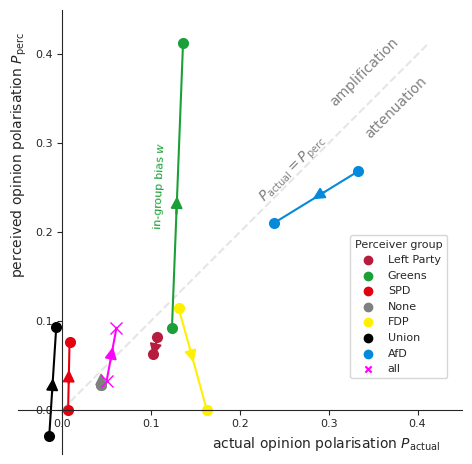

In [7]:
fig, ax = plt.subplots(1,1, figsize=(12/2.54, 12/2.54))

c = [colours[kuerzel2party[ind[0]]] for ind in dfPxA.index]
for i, (_, row) in enumerate(dfPxA.iterrows()):
    ax.plot([row["OP_w1"], row["OP_w0"]], [row["Pol_w1"], row["Pol_w0"]],  marker="o", markeredgecolor="None", linestyle="-", color=c[i], lw=1.5, markerfacecolor=c[i], ms=8)
    d  = np.array([row["OP_w1"]- row["OP_w0"], row["Pol_w1"]-row["Pol_w0"]])
    ax.arrow(row["OP_w0"]+0.4*d[0], row["Pol_w0"]+0.4*d[1], 0.02*d[0], 0.02*d[1], lw=1, color=c[i], head_width=0.012, head_length=0.012 )

pol = meand_w1[10][10] - meand_w1[8][8]
op = meand_w1[10][8] - meand_w1[8][8]
pol0 = meand_w0[10][10] - meand_w0[8][8]
op0 = meand_w0[10][8] - meand_w0[8][8]
ax.plot([op, op0], [pol, pol0], marker="x", ms=8, color="magenta", zorder=100)
d  = np.array([op-op0, pol-pol0])
ax.arrow(op0+0.4*d[0], pol0+0.4*d[1], 0.02*d[0], 0.02*d[1], lw=1, color="magenta", head_width=0.012, head_length=0.012 )

ax.set_xlabel(r"actual opinion polarisation $P_{\rm actual}$", x=0.95, ha="right", fontsize=bigfs)# =d(\mathcal{\Delta}_{10}, \mathcal{T}_{8}) - d(\mathcal{\Delta}_{8}, \mathcal{T}_{8})
ax.set_ylabel(r"perceived opinion polarisation $P_{\rm perc}$", y=0.95, ha="right", fontsize=bigfs) #=d(\mathcal{\Delta}_{10}, \mathcal{T}_{10}) - d(\mathcal{\Delta}_{8}, \mathcal{T}_{8})$

ax.text(0.27-0.01, 0.27, r"$P_{\rm actual}=P_{\rm perc}$", va="center", ha="center",color="grey", fontsize=bigfs, rotation=45)
ax.text(0.38-0.04, 0.38, "amplification", fontsize=bigfs, ha="center", va="center", color="grey", rotation=45)
ax.text(0.365+0.01, 0.34, "attenuation", fontsize=bigfs,  ha="center", va="center", color="grey", rotation=45)

for party in parties:
    ax.scatter([],[],marker="o", label=party, color=colours[party])
ax.scatter([],[], marker="x", s=20, color="magenta", label="all")

ax.legend(title="Perceiver group",  fontsize=smallfs, bbox_to_anchor=(0.97, 0.52),
          bbox_transform=fig.transFigure) # loc="center right",

alpha = np.arctan((dfPxA.loc["g"].Pol_w1-dfPxA.loc["g"].Pol_w0)/(dfPxA.loc["g"].OP_w1-dfPxA.loc["g"].OP_w0)) * 180/np.pi
ax.text(0.5*(dfPxA.loc["g"].OP_w0+dfPxA.loc["g"].OP_w1)- 0.02, 0.5*(dfPxA.loc["g"].Pol_w0+dfPxA.loc["g"].Pol_w1), "in-group bias $w$", va="center", ha="center", rotation=alpha, color=colours["Greens"])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim(-0.05, 0.45)
ax.set_ylim(-0.05, 0.45)
ax.set_aspect("equal")
ax.plot([0,max(dfPxA["Pol_w1"])], [0,max(dfPxA["Pol_w1"])], "--", color="grey", alpha=0.2)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

#fig.set_facecolor("whitesmoke")
fig.subplots_adjust(left=0.05, right=0.99, top=0.99, bottom=0.04)
plt.savefig("figs/P-over-OP_PxA_w1-0.pdf")
plt.savefig("figs/P-over-OP_PxA_w1-0.png", dpi=600)

# PxP

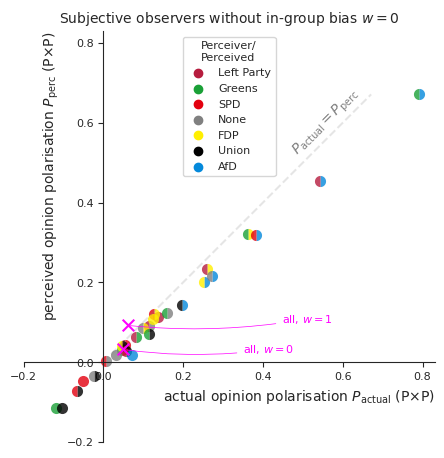

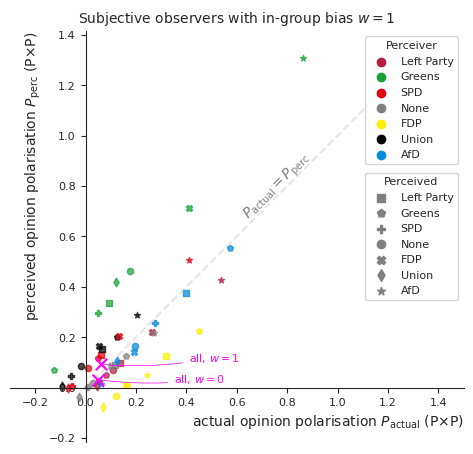

In [8]:
for w in [0,1]:
    fig, ax = plt.subplots(1,1, figsize=(12/2.54, 12/2.54))
    partynames = [p for p in parties]
    c = [colours[kuerzel2party[ind[0]]] for ind in dfPxP.index]

    if w==1:
        #################################
        #########      w=1     ##########
        #################################
        shapes = dict(zip(partynames, ["s", "p", "P", "o", "X", "d","*"]))
        s = [shapes[kuerzel2party[ind[1]]] for ind in dfPxP.index]
        for i, (_, row) in enumerate(dfPxP.iterrows()):
            #plt.scatter(row['x_values'], row['y_values'], marker=row['shapes'], s=100)
            ax.scatter(row[f"OP_w{w}"], row[f"Pol_w{w}"],  c=c[i], marker=s[i], alpha=0.7, s=20)
            
        for party, shape in shapes.items():
            ax.scatter([],[],marker=shape, label=party, color="grey")
        ax.legend(title="Perceived", loc="center right")
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks([])
        for spine in ["left", "right", "top", "bottom"]:
            ax2.spines[spine].set_visible(False)
        for party in parties:
            ax2.scatter([],[],marker="o", label=party, color=colours[party])
        ax2.legend(title="Perceiver", loc="upper right")

        ax.set_xlim(-0.3, 1.5)
        ax.set_ylim(-0.3, 1.5)

    elif w==0:
        #################################
        #########      w=0     ##########
        #################################
        plotted = []
        r1 = 0.5       # 50%
        r2 = r1 + 0.5  # 100%
        x1 = np.cos(2 * np.pi * np.linspace(0.25, 0.25+r1))
        y1 = np.sin(2 * np.pi * np.linspace(0.25, 0.25+r1))
        leftcircle = np.row_stack([[0, 0], np.column_stack([x1, y1])])

        x2 = np.cos(2 * np.pi * np.linspace(0.25+r1, 0.25+r2))
        y2 = np.sin(2 * np.pi * np.linspace(0.25+r1, 0.25+r2))
        rightcircle = np.row_stack([[0, 0], np.column_stack([x2, y2])])

        for i, (_, row) in enumerate(dfPxP.iterrows()):
            if row.obd==row.obs:
                marker = "o"
            else:
                marker = leftcircle if (row.obd, row.obs) in plotted else rightcircle
            ax.plot(row["OP_w0"], row["Pol_w0"],  marker=marker, markeredgecolor="None", linestyle='None', markerfacecolor=c[i], alpha=0.8, ms=8)
            plotted.append((row.obs, row.obd))
        
        
        for party in parties:
            ax.scatter([],[],marker="o", label=party, color=colours[party])
        ax.legend(title="Perceiver/"+"\n"+"Perceived", loc="upper center", fontsize=smallfs)
        
        ax.set_xlim(-0.2, 0.83)
        ax.set_ylim(-0.2, 0.83)


    # ALL INDIVIDUALS
    pol = meand_w1[10][10] - meand_w1[8][8]
    op = meand_w1[10][8] - meand_w1[8][8]
    ax.scatter([op], [pol], marker="x", s=70, c="magenta", zorder=100)
    #ax.text(op+0.1, pol+0.05, r"all $w=1$", va="top", color="pink")
    ax.annotate(r"all, $w=1$", (op, pol), (op+0.45, pol), va="bottom", ha="center", arrowprops=dict(arrowstyle="-", lw=0.5, connectionstyle="arc3,rad=-0.07", color="magenta"), color="magenta", fontsize=smallfs)

    pol0 = meand_w0[10][10] - meand_w0[8][8]
    op0 = meand_w0[10][8] - meand_w0[8][8]
    ax.scatter([op0], [pol0], marker="x", s=70, c="magenta", zorder=100)
    ax.annotate(r"all, $w=0$", (op0, pol0), (op0+0.3, pol0), va="center", ha="left", arrowprops=dict(arrowstyle="-", lw=0.5, connectionstyle="arc3,rad=-0.07", color="magenta"), color="magenta", fontsize=smallfs)
    #ax.annotate(r"$P_{\rm op}=P$", (1, 1), (0.85, 1), va="center", ha="right", arrowprops=dict(arrowstyle="-", lw=0.5, connectionstyle="arc3,rad=-0.05", color="grey"), color="grey", fontsize=smallfs)
    PeualPy = 0.8 if w==1 else 0.6
    ax.text(PeualPy-0.04, PeualPy, r"$P_{\rm actual}=P_{\rm perc}$", va="center", ha="center",color="grey", fontsize=bigfs, rotation=45)

    #ax.set_xlabel("actual party-by-party opinion polarisation\n"+r"$P^{w="+f"{w}"+r"}_{\rm op}=d(\mathcal{\Delta}_{10}, \mathcal{T}_{8}) - d(\mathcal{\Delta}_8, \mathcal{T}_{8})$ ", x=0.95, ha="right", fontsize=bigfs)
    #ax.set_ylabel("perceived party-by-party polarisation\n"+r"$P^{w="+f"{w}"+r"}= d(\mathcal{\Delta}_{10}, \mathcal{T}_{10}) - d(\mathcal{\Delta}_8, \mathcal{T}_{8})$", y=0.95, ha="right", fontsize=bigfs)
    ax.set_xlabel(r"actual opinion polarisation $P_{\rm actual}$ (P$\times$P)", x=1, ha="right", fontsize=bigfs) # ^{w="+f"{w}"+r"}_{\rm op}=d(\mathcal{\Delta}_{10}, \mathcal{T}_{8}) - d(\mathcal{\Delta}_8, \mathcal{T}_{8})
    ax.set_ylabel(r"perceived opinion polarisation $P_{\rm perc}$ (P$\times$P)", y=1, ha="right", fontsize=bigfs)#^{w="+f"{w}"+r"}= d(\mathcal{\Delta}_{10}, \mathcal{T}_{10}) - d(\mathcal{\Delta}_8, \mathcal{T}_{8})$"

    ax.set_aspect("equal")


    ax.plot([0,max(dfPxP[f"Pol_w{w}"])], [0,max(dfPxP[f"Pol_w{w}"])], "--", color="grey", alpha=0.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.set_aspect("equal")
    #fig.tight_layout()
    #fig.set_facecolor("gainsboro")
    ax.set_title(f"Subjective observers with{('out' if w==0 else '')} in-group bias $w={w}$", fontsize=bigfs)
    fig.subplots_adjust(left=0.03, right=0.99, top=0.93, bottom=0.06)
    plt.savefig(f"figs/P-over-OP_PxP_w{w}.pdf")
    plt.savefig(f"figs/P-over-OP_PxP_w{w}.png", dpi=600)


# Bootstrap

In [9]:
import pickle

n8, n10 = filtered_data.essround.value_counts().sort_index().values
print("Sample Sizes", n8, n10)

percentages = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3][::-1]
P_n_arr = dict(zip(percentages, [[] for _ in percentages]))
P_n_percarr = dict(zip(percentages, [[] for _ in percentages]))
P_n_oparr = dict(zip(percentages, [[] for _ in percentages]))

rerun = False
if rerun: 
    for n in percentages:
        s0 = time.time()
        for _ in range(0, 100):
            sample8 = filtered_data.loc[filtered_data.essround==8, :].reset_index().iloc[np.random.choice(n8, size=int(n8*n), replace=False)]
            sample10 = filtered_data.loc[filtered_data.essround==10, :].reset_index().iloc[np.random.choice(n10, size=int(n10*n), replace=False)]
            sampleData = pd.concat([sample8, sample10])
            if "level_0" in sampleData.columns:
                sampleData.drop(columns="level_0", inplace=True)
            sampleData = sampleData.reset_index()
            CSS_dict, Trafo = get_Trafo(sampleData, parties, waves, variables)
            P, Pperc, Pop = calc_polarisation(sampleData, waves, variables, Trafo)
            P_n_arr[n].append(P)
            P_n_percarr[n].append(Pperc)
            P_n_oparr[n].append(Pop)
        print(n, P_n_arr[n])
        s1 = time.time()-s0
        print(f"time elapsed {int(s1/60)}min, {int(np.mod(s1, 60))}s")

    # with open('P_n_arr_bootstrap.pkl', 'wb') as outp:
    #     pickle.dump(P_n_arr, outp, pickle.HIGHEST_PROTOCOL)
    # with open('P_n_percarr_bootstrap.pkl', 'wb') as outp:
    #     pickle.dump(P_n_percarr, outp, pickle.HIGHEST_PROTOCOL)
    # with open('P_n_oparr_bootstrap.pkl', 'wb') as outp:
    #     pickle.dump(P_n_oparr, outp, pickle.HIGHEST_PROTOCOL)
else:
    folder = "/home/peter.steiglechner/labspaces/cognitive-biases-in-opinion-formation/data/ms3-subjOpSpace/results_bootstrap/"
    with open(folder+'P_n_arr_bootstrap.pkl', 'rb') as f:
        P_n_arr = pickle.load(f)
    with open(folder+'P_n_percarr_bootstrap.pkl', 'rb') as f:
        P_n_percarr = pickle.load(f)
    with open(folder+'P_n_oparr_bootstrap.pkl', 'rb') as f:
        P_n_oparr = pickle.load(f)



Sample Sizes 2737 7807


In [10]:
filtered_data = filtered_data.loc[:, ["essround", "anweight", "identity"]+variables]
CSS_dict, Trafo = get_Trafo(filtered_data, parties, waves, variables)
meand_w0, meand_w1 = calc_polarisation(filtered_data, waves, variables, Trafo)
P_perc1 = meand_w1[10][10] - meand_w1[8][8]
P_X1 = meand_w1[10][10] - meand_w1[10][8]
P_actual1 = meand_w1[10][8] - meand_w1[8][8]

Opinions from wave 8 (# (2737,)), with transformation matrices from wave 8. Time elapsed: 0s
Opinions from wave 10 (# (7807,)), with transformation matrices from wave 8. Time elapsed: 4s
Opinions from wave 10 (# (7807,)), with transformation matrices from wave 10. Time elapsed: 8s


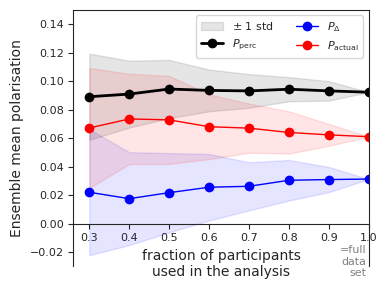

In [14]:

Parr = []
Ppercarr = []
Poparr = []
fig, ax = plt.subplots(1,1, figsize=(10/2.54,7/2.54))
slowerP = []
shigherP = []
slowerPperc = []
shigherPperc = []
slowerPop = []
shigherPop = []

for n in percentages:
    Parr.append(np.array(P_n_arr[n]).mean())
    Ppercarr.append(np.array(P_n_percarr[n]).mean())
    Poparr.append(np.array(P_n_oparr[n]).mean())
    #ax.scatter([n-0.01 for _ in range(len(P_n_arr[n]))], P_n_arr[n], alpha=0.3, color="k", edgecolors=(0,0,0,0.8), s=10)
    #ax.scatter([n for _ in range(len(P_n_percarr[n]))], P_n_percarr[n], alpha=0.3, color="b", edgecolors=(0,0,0,0.8), s=10)
    #ax.scatter([n+0.01 for _ in range(len(P_n_oparr[n]))], P_n_oparr[n], alpha=0.3, color="r", edgecolors=(0,0,0,0.8), s=10)
    
    slowerP.append(np.array(P_n_arr[n]).mean() - np.array(P_n_arr[n]).std())
    shigherP.append(np.array(P_n_arr[n]).mean() + np.array(P_n_arr[n]).std())
    slowerPperc.append(np.array(P_n_percarr[n]).mean() - np.array(P_n_percarr[n]).std())
    shigherPperc.append(np.array(P_n_percarr[n]).mean() + np.array(P_n_percarr[n]).std())
    slowerPop.append(np.array(P_n_oparr[n]).mean() - np.array(P_n_oparr[n]).std())
    shigherPop.append(np.array(P_n_oparr[n]).mean() + np.array(P_n_oparr[n]).std())
    
    # slowerP.append(np.percentile(P_n_arr[n], 5))
    # shigherP.append(np.percentile(P_n_arr[n], 95))
    # slowerPperc.append(np.percentile(P_n_percarr[n], 5))
    # shigherPperc.append(np.percentile(P_n_percarr[n], 95))
    # slowerPop.append(np.percentile(P_n_oparr[n], 5))
    # shigherPop.append(np.percentile(P_n_oparr[n], 95))
    

ax.fill_between(percentages+[1], slowerP+[P_perc1], shigherP+[P_perc1], color="k", alpha=0.1, label="$\pm$ 1 std")
ax.fill_between(percentages+[1], slowerPperc+[P_X1], shigherPperc+[P_X1], color="b", alpha=0.1)
ax.fill_between(percentages+[1], slowerPop+[P_actual1], shigherPop+[P_actual1], color="r", alpha=0.1)
Parr.append(P_perc1)
Ppercarr.append(P_X1)
Poparr.append(P_actual1)
ax.plot(percentages+[1], Parr, "-o", color="k", lw=2, label=r"$P_{\rm perc}$")
ax.plot(percentages+[1], Ppercarr, "-o",color="b", lw=1, label=r"$P_{\rm \Delta}$")
ax.plot(percentages+[1], Poparr, "-o", color="r", lw=1, label=r"$P_{\rm actual}$")
ax.legend(fontsize=smallfs, ncol=2)
ax.set_xlim(0.26,1)
ax.text(0.995, -0.015, "=full\ndata\nset", ha="right", va="top", color="grey", fontsize=smallfs)
ax.set_ylim(-0.03, 0.15)
ax.spines["bottom"].set_position('zero')
ax.set_xlabel("fraction of participants\nused in the analysis", fontsize=bigfs)
ax.set_ylabel("Ensemble mean polarisation", fontsize=bigfs)
#fig.set_facecolor("grey")
fig.subplots_adjust(left=0.2, right=0.95, top=0.98, bottom=0.05)
plt.savefig("figs/Bootstrap_reducedDatasize.pdf")
plt.savefig("figs/Bootstrap_reducedDatasize.png", dpi=600)